In [2]:
#
# This example shows how to load Bruker Skyscan data in a form usable by the
# well-known tomopy tomographic reconstruction library commonly used at 
# synchrotons. 
#
# This block implements a load_skyscan function by analogy to dxchange's
# similar functions for loading synchrotron tomography data. It requires
# a single parameter:
#   fname: name of the Skyscan data collection log file.
# It outputs:
#   ndarray: 3D tomographic data stack (normalized if input is normalized)
#   ndarray: 1D theta in radian
#   boolean: True if data is normalized, False if not
#      dict: all configuration information/metadata read from the log file
#
# This function utilizes several components to do the reading.
#
# configparser is a standard python module for reading "Windows INI"-type
# files that contain key=value pairs in sections. For Bruker Skyscan image
# data, the "log" file that goes along with each data collection is in
# this format, so we use configparser to automatically parse the file.
#
# The important parameters for loading data for reconstruction are in the
# "Acquisition" section, specifically:
#   filename prefix: the prefix that begins all data filenames
#   rotation step (deg): the angular difference between each pair of images
# We also use the following values for sanity checks:
#   flat field correction: Skyscan's can automatically output
#      data that has already been corrected for detector flat (bright) field
#      respopnse, which simplifies normalization. If "ON", then we do
#      the final normalization step. If "OFF", we carry out no normalization.
#   depth (bits): if flat field correction is "ON", this is used to determine
#      the maximum possible detector value as 2^bits - 1.
#   image format: we make sure this is tiff
#   number of files: this is the number of files, including each image as
#      well as the "arc" image. Used to validate we have the proper files.
#
# Further, this example involves path and filename manipulation, which we
# perform using the python pathlib to avoid system-specific-isms.
#
# If the data has already had a flat field correction, 
# 
import configparser
from pathlib import Path
import numpy as np
import dxchange.reader as dxreader

def load_skyscan(fname):
    normalized = False

    # load log file
    config = configparser.ConfigParser()
    config.read(fname)
    # convert to dict of dicts
    config = {k:dict(config[k]) for k in config.keys()}
    
    # Validate image format
    assert config['Acquisition']['image format'] == "TIFF", "Skyscan data must be in TIFF format"
    
    # Get base directory with images, the image prefix
    # and read all the tifs present that match the
    # filename sequence expected for an image stack.
    # Ensure this matches the sepect number of files
    baseDir = Path(fname).parent
    prefix = config['Acquisition']['filename prefix']
    tiffs = sorted(baseDir.glob(prefix + "[0-9]*.tif"))
    num_files = len(tiffs)
    assert num_files == int(config['Acquisition']['number of files'])-1, "Mismatch in number of tif files found vs log file value"
    
    # Now we build the indices and the 1D theta array
    ind = list(range(0,num_files))
    theta = np.array(ind)*float(config['Acquisition']['rotation step (deg)'])/180*np.pi;
    
    # Read the TIFF stack using dxreader's tiff_stack reader
    tomo = dxreader.read_tiff_stack(tiffs[0],ind)
    
    # If flat field correction is on, do final normalization
    if config['Acquisition']['flat field correction'] == "ON":
        normalized = True
        maxval = 2**int(config['Acquisition']['depth (bits)'])-1
        minval = np.amin(tomo)
        tomo = (tomo-minval)/(maxval-minval)
    
    # Return values
    return tomo, theta, normalized, config

In [4]:
#
# This block executes an actual reconstruction, following the example:
#    https://tomopy.readthedocs.io/en/latest/ipynb/tomopy.html
# It uses a very simple (but fast!) reconstruction algorith, You will
# likely want to adjust this to match your scientific problem's needs.
#
import logging
import tomopy

# Turn on informational logging
logging.basicConfig(level=logging.INFO)

# Step 1: Load a sample image stack
tomo, theta,_,_ = load_skyscan("Input/YbB12_resistivity_leads.log")

# Step 2: Find the rotation center (basically the y column about which the image rotates)
rot_center = tomopy.find_center(tomo, theta)

# Step 3: Convert from transmission to absorbance by taking -log(tomo)
proj = tomopy.minus_log(tomo)

# Step 4: Do the reconstruction. Here we use a very simple algorithm.
# See the tomopy documentation for other choices.
recon = tomopy.recon(proj, theta, center=rot_center, algorithm='gridrec', sinogram_order=False)

ERROR:dxchange.reader:File name must be a string
INFO:dxchange.reader:Data successfully imported: /home/idies/workspace/Temporary/tmcquee2/scratch/Input/YbB12_resistivity_leads0000.tif
INFO:dxchange.reader:Data successfully imported: /home/idies/workspace/Temporary/tmcquee2/scratch/Input/YbB12_resistivity_leads0000.tif
INFO:dxchange.reader:Data successfully imported: /home/idies/workspace/Temporary/tmcquee2/scratch/Input/YbB12_resistivity_leads0001.tif
INFO:dxchange.reader:Data successfully imported: /home/idies/workspace/Temporary/tmcquee2/scratch/Input/YbB12_resistivity_leads0002.tif
INFO:dxchange.reader:Data successfully imported: /home/idies/workspace/Temporary/tmcquee2/scratch/Input/YbB12_resistivity_leads0003.tif
INFO:dxchange.reader:Data successfully imported: /home/idies/workspace/Temporary/tmcquee2/scratch/Input/YbB12_resistivity_leads0004.tif
INFO:dxchange.reader:Data successfully imported: /home/idies/workspace/Temporary/tmcquee2/scratch/Input/YbB12_resistivity_leads0005.tif

INFO:dxchange.reader:Data successfully imported: /home/idies/workspace/Temporary/tmcquee2/scratch/Input/YbB12_resistivity_leads0059.tif
INFO:dxchange.reader:Data successfully imported: /home/idies/workspace/Temporary/tmcquee2/scratch/Input/YbB12_resistivity_leads0060.tif
INFO:dxchange.reader:Data successfully imported: /home/idies/workspace/Temporary/tmcquee2/scratch/Input/YbB12_resistivity_leads0061.tif
INFO:dxchange.reader:Data successfully imported: /home/idies/workspace/Temporary/tmcquee2/scratch/Input/YbB12_resistivity_leads0062.tif
INFO:dxchange.reader:Data successfully imported: /home/idies/workspace/Temporary/tmcquee2/scratch/Input/YbB12_resistivity_leads0063.tif
INFO:dxchange.reader:Data successfully imported: /home/idies/workspace/Temporary/tmcquee2/scratch/Input/YbB12_resistivity_leads0064.tif
INFO:dxchange.reader:Data successfully imported: /home/idies/workspace/Temporary/tmcquee2/scratch/Input/YbB12_resistivity_leads0065.tif
INFO:dxchange.reader:Data successfully imported:

INFO:dxchange.reader:Data successfully imported: /home/idies/workspace/Temporary/tmcquee2/scratch/Input/YbB12_resistivity_leads0120.tif
INFO:dxchange.reader:Data successfully imported: /home/idies/workspace/Temporary/tmcquee2/scratch/Input/YbB12_resistivity_leads0121.tif
INFO:dxchange.reader:Data successfully imported: /home/idies/workspace/Temporary/tmcquee2/scratch/Input/YbB12_resistivity_leads0122.tif
INFO:dxchange.reader:Data successfully imported: /home/idies/workspace/Temporary/tmcquee2/scratch/Input/YbB12_resistivity_leads0123.tif
INFO:dxchange.reader:Data successfully imported: /home/idies/workspace/Temporary/tmcquee2/scratch/Input/YbB12_resistivity_leads0124.tif
INFO:dxchange.reader:Data successfully imported: /home/idies/workspace/Temporary/tmcquee2/scratch/Input/YbB12_resistivity_leads0125.tif
INFO:dxchange.reader:Data successfully imported: /home/idies/workspace/Temporary/tmcquee2/scratch/Input/YbB12_resistivity_leads0126.tif
INFO:dxchange.reader:Data successfully imported:

INFO:dxchange.reader:Data successfully imported: /home/idies/workspace/Temporary/tmcquee2/scratch/Input/YbB12_resistivity_leads0181.tif
INFO:dxchange.reader:Data successfully imported: /home/idies/workspace/Temporary/tmcquee2/scratch/Input/YbB12_resistivity_leads0182.tif
INFO:dxchange.reader:Data successfully imported: /home/idies/workspace/Temporary/tmcquee2/scratch/Input/YbB12_resistivity_leads0183.tif
INFO:dxchange.reader:Data successfully imported: /home/idies/workspace/Temporary/tmcquee2/scratch/Input/YbB12_resistivity_leads0184.tif
INFO:dxchange.reader:Data successfully imported: /home/idies/workspace/Temporary/tmcquee2/scratch/Input/YbB12_resistivity_leads0185.tif
INFO:dxchange.reader:Data successfully imported: /home/idies/workspace/Temporary/tmcquee2/scratch/Input/YbB12_resistivity_leads0186.tif
INFO:dxchange.reader:Data successfully imported: /home/idies/workspace/Temporary/tmcquee2/scratch/Input/YbB12_resistivity_leads0187.tif
INFO:dxchange.reader:Data successfully imported:

In [5]:
# 
# This block demonstrates visulation of the reconstruction. The process of
# appropriately viewing volumetric data is a substantial area of research
# in and of itself, with different possible approaches, including isosurface
# (constant value) plotting, volumetric projection, gradient-based lighting
# volumetric rendering, etc. 
#
# Here we do the visualization using volumetric projection with a gaussian
# transfer function. The default levels were chosen based on an initial 
# viewing of the data.
#
# See, e.g., https://github.com/maartenbreddels/ipyvolume/issues/74 and
# references therein for other options.
#
import ipyvolume as ipv
ipv.quickvolshow(recon, level_width=0.01, data_min=0.1, level=[0.75,0.75,0.75], opacity=[0.2,0.2,0.2])

/home/idies/miniconda3/envs/py37/lib/python3.7/site-packages/ipyvolume/widgets.py:241: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_view = self.data_original[view]
/home/idies/miniconda3/envs/py37/lib/python3.7/site-packages/ipyvolume/utils.py:207: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data = (data[slices1] + data[slices2]) / 2


In [6]:
#
# This block demonstrates carrying out some statistical visualization of
# the values in the reconstructed volume. Because the reconstruction can
# generate invalid values (NaNs -- Not a Number), we use a numpy masked
# array to only consider values that are not NaNs
#
import numpy.ma as ma
recon_masked = ma.masked_invalid(recon)
recon_hist=np.histogram(recon_masked,bins=500,range=(np.amin(recon_masked),np.amax(recon_masked)))
recon_bins=np.array([(recon_hist[1][i]+recon_hist[1][i+1])/2 for i in range(0,len(recon_hist[1])-1)])

/home/idies/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/idies/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


/home/idies/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/home/idies/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/home/idies/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


Text(0, 0.5, 'log(Counts)')

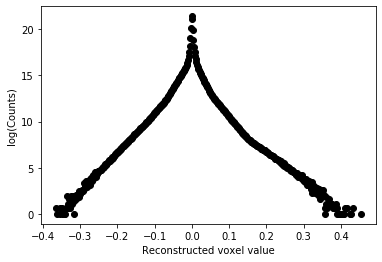

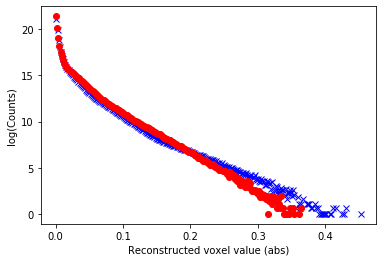

In [12]:
#
# Plotting of the histogram data in two ways -- first to show the distribution,
# and then to show the difference between the positive and negative halves --
# negative values are unphysical and reflect the errors in the reconstruction, so
# the comparison can highlight where there is real data in the positive half.
#
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(recon_bins,np.log(recon_hist[0]),'ko')
plt.xlabel('Reconstructed voxel value')
plt.ylabel('log(Counts)')
plt.figure()
plt.plot(recon_bins[recon_bins >= 0.0],np.log(recon_hist[0])[recon_bins >= 0.0],'bx')
plt.plot(-recon_bins[recon_bins < 0.0],np.log(recon_hist[0])[recon_bins < 0.0],'ro')
plt.xlabel('Reconstructed voxel value (abs)')
plt.ylabel('log(Counts)')